Importuje potrzebne biblioteki i dokonuje podziału na zbiór testowy i treningowy 30-70  

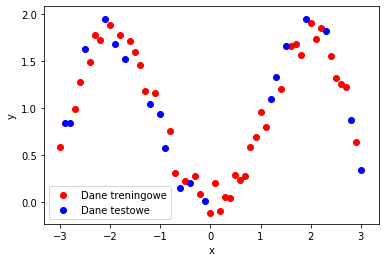

In [132]:
import numpy as np 
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

source="dane3.txt"
x=[]
y=[]

with open(source) as lines:
    for line in lines:
        args = line.split(" ")
        x.append(float(args[0]))
        y.append(float(args[1]))

x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.7)

x_train=np.array(x_train)
x_test=np.array(x_test)
y_train=np.array(y_train)
y_test=np.array(y_test)


plt.xlabel('x')
plt.ylabel('y')
plt.scatter(x_train, y_train, color='red', label='Dane treningowe')
plt.scatter(x_test, y_test, color='blue', label='Dane testowe')
plt.legend()
plt.show()

Buduje i trenuje początkową sieć. Wybieram liczbę epok = 20, ponieważ dla małego zbioru danych powinna to być liczba wystarczająca do określenia bazowych wartości straty i błędu.

In [165]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(units=2, input_shape=(1,)))
model.add(layers.Activation('relu'))
model.add(layers.Dense(units=1))

model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['mean_squared_error', 'mean_absolute_error'])

history = model.fit(x_train,
                    y_train,
                    epochs=20,
                    batch_size=8,
                    verbose=0)


predictions = model.predict(x_test)


19/19 [==============================] - 0s 52us/step
Dokładność wytrenowanego modelu:
	Etykiety:  ['loss', 'mean_squared_error', 'mean_absolute_error']
	Wartości:  [1.3117518424987793, 1.3117518424987793, 0.8700617551803589]
	Wspolczynnik przetrenowania:  [1.44343753 1.44343766 1.2708378 ]


Dokonuje ewaluacji sieci. Ponieważ nie używamy zbioru walidacyjnego do stwierdzania czy sieć jest przetrenowana, poza porównywaniem rezultatów dla zbioru testowego dodałem dodatkowy parametr. Jest to bardzo prosta weryfikacja porównująca dokładność sieci dla zbioru treningowego i testowego, jeśli sieć jest przetrenowana wartości współczynnika będą wyraźnie wzrastać.

In [168]:
results1 = model.evaluate(x_train, y_train)
results2 = model.evaluate(x_test, y_test)
overfittingFactor=np.asarray(results2)/np.asarray(results1)

print('Dokładność wytrenowanego modelu:')
print('\tEtykiety: ', model.metrics_names)
print('\tWartości: ', results2)
print('\tWspolczynnik przetrenowania: ', overfittingFactor)

19/19 [==============================] - 0s 0us/step
Dokładność wytrenowanego modelu:
	Etykiety:  ['loss', 'mean_squared_error', 'mean_absolute_error']
	Wartości:  [1.3117518424987793, 1.3117518424987793, 0.8700617551803589]
	Wspolczynnik przetrenowania:  [1.44343753 1.44343766 1.2708378 ]


Wykonuje predykcje dla danych testowych i rysuje wykres

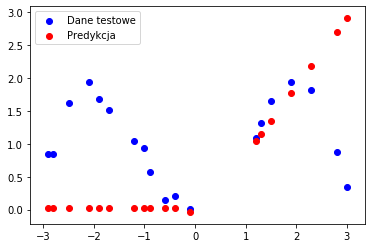

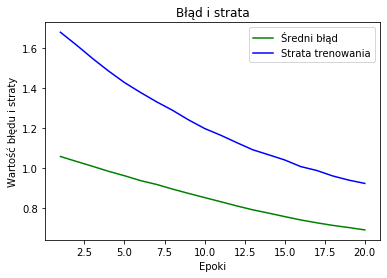

In [167]:
def printResults(x, y, pred):
    plt.clf()
    plt.scatter(x, y, color='blue', label='Dane testowe')
    plt.scatter(x, pred, color='red', label='Predykcja')
    plt.legend()
    plt.show()

printResults(x_test, y_test, predictions)

def printLossAndError(error, loss, epochs):
    plt.clf()
    plt.plot(epochs, error, 'g', label='Średni błąd')
    plt.plot(epochs, loss, 'b', label='Strata trenowania')
    plt.title('Błąd i strata')
    plt.xlabel('Epoki')
    plt.ylabel('Wartość błędu i straty')
    plt.legend()
    plt.show()

mse=history.history['mean_absolute_error']
loss=history.history['loss']
epochs = range(1, len(mse) + 1)
printLossAndError(mse, loss, epochs)

Jak widać z pierwszego wykresu sieć jest za mała skomplikowana, żeby wykonywać dokładne predykcje co do wartości danych testowych. Widzimy również że wzgledem zbioru wartości danych <0,3> średni błąd jest znaczący. Jako statystyk używam MAE i MSE z ewaluacji.

Poniższe zmiany zostały wybrane na podstawie empirycznych prób i analizy zbioru danych. Przedstawiam przykładowy proces optymalizacji. 

Z wykresów błędu i straty widać że zwiększenie liczby epok powinno wyraźnie poprawić dokładność sieci. Spróbujmy na początek to zrobić.

19/19 [==============================] - 0s 53us/step
Dokładność wytrenowanego modelu:
	Etykiety:  ['loss', 'mean_squared_error', 'mean_absolute_error']
	Wartości:  [0.38031426072120667, 0.38031426072120667, 0.514183521270752]
	Wspolczynnik przetrenowania:  [1.58499638 1.58499637 1.22750069]


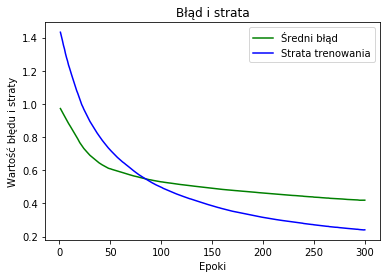

In [179]:
model = models.Sequential()
model.add(layers.Dense(units=2, activation='relu', input_shape=(1,)))
model.add(layers.Dense(units=1))

model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['mean_squared_error', 'mean_absolute_error'])

history = model.fit(x_train,
                    y_train,
                    epochs=300,
                    batch_size=8,
                    verbose=0)

results1 = model.evaluate(x_train, y_train)
results2 = model.evaluate(x_test, y_test)
overfittingFactor=np.asarray(results2)/np.asarray(results1)

print('Dokładność wytrenowanego modelu:')
print('\tEtykiety: ', model.metrics_names)
print('\tWartości: ', results2)
print('\tWspolczynnik przetrenowania: ', overfittingFactor)

mse=history.history['mean_absolute_error']
loss=history.history['loss']
epochs = range(1, len(mse) + 1)
printLossAndError(mse, loss, epochs)

Jak widać 15-krotne zwiększenie liczby epok nie wykazuje oznak przetrenowania, lecz poprawa rezultatów jest coraz mniejsza. Nie ma sensu zwiększać dalej liczby epok. Spróbujmy więc zmienić liczbę neuronów w warstwie, ponieważ z pierwszego wykresu wiemy, że rozkład danych jest w przybliżeniu wielomianem co najmniej 4 stopnia. Większa liczba neuronów powinna pomóc w regresji.

In [180]:
model = models.Sequential()
model.add(layers.Dense(units=16, activation='relu', input_shape=(1,)))
model.add(layers.Dense(units=1))

model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['mean_squared_error', 'mean_absolute_error'])

history = model.fit(x_train,
                    y_train,
                    epochs=300,
                    batch_size=8,
                    verbose=0)

results = model.evaluate(x_test, y_test)

print('Dokładność wytrenowanego modelu:')
print('\tEtykiety: ', model.metrics_names)
print('\tWartości: ', results)


19/19 [==============================] - 0s 3ms/step
Dokładność wytrenowanego modelu:
	Etykiety:  ['loss', 'mean_squared_error', 'mean_absolute_error']
	Wartości:  [0.3416648805141449, 0.3416648805141449, 0.4839901626110077]


Widać poprawę wyniku, spróbujmy zwiększyć liczbę warstw

In [192]:
model = models.Sequential()
model.add(layers.Dense(units=16, activation='relu', input_shape=(1,)))
model.add(layers.Dense(units=16, activation='relu'))
model.add(layers.Dense(units=16, activation='relu'))
model.add(layers.Dense(units=16, activation='relu'))
model.add(layers.Dense(units=1))

model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['mean_squared_error', 'mean_absolute_error'])

history = model.fit(x_train,
                    y_train,
                    epochs=200,
                    batch_size=8,
                    verbose=0)

results = model.evaluate(x_test, y_test)

print('Dokładność wytrenowanego modelu:')
print('\tEtykiety: ', model.metrics_names)
print('\tWartości: ', results)


19/19 [==============================] - 0s 4ms/step
Dokładność wytrenowanego modelu:
	Etykiety:  ['loss', 'mean_squared_error', 'mean_absolute_error']
	Wartości:  [0.16220994293689728, 0.16220994293689728, 0.2866833209991455]


Udało nam się ponownie poprawić rezultaty, wyniki są już znacząco lepsze niż na początku optymalizacji, na koniec spróbujmy zmienić optymalizator

In [189]:
model = models.Sequential()
model.add(layers.Dense(units=16, activation='relu', input_shape=(1,)))
model.add(layers.Dense(units=16, activation='relu'))
model.add(layers.Dense(units=16, activation='relu'))
model.add(layers.Dense(units=16, activation='relu'))
model.add(layers.Dense(units=1))

model.compile(optimizer='RMSProp',
              loss='mean_squared_error',
              metrics=['mean_squared_error', 'mean_absolute_error'])

history = model.fit(x_train,
                    y_train,
                    epochs=300,
                    batch_size=8,
                    verbose=0)

results = model.evaluate(x_test, y_test)

print('Dokładność wytrenowanego modelu:')
print('\tEtykiety: ', model.metrics_names)
print('\tWartości: ', results)


19/19 [==============================] - 0s 8ms/step
Dokładność wytrenowanego modelu:
	Etykiety:  ['loss', 'mean_squared_error', 'mean_absolute_error']
	Wartości:  [0.04166274890303612, 0.04166274890303612, 0.1691729575395584]


Przy tym samym stopniu uczenia dla kilku innych optymalizatorów RMSProp uzyskuje najlepsze wyniki, podobne do optymalizatora Adam. Dla tego podziału zbiorów RMSProp jest lepszy. Przedstawmy końcową, poprawioną sieć.  

19/19 [==============================] - 0s 7ms/step
Dokładność wytrenowanego modelu:
	Etykiety:  ['loss', 'mean_squared_error', 'mean_absolute_error']
	Wartości:  [0.02486892230808735, 0.02486892230808735, 0.13268126547336578]


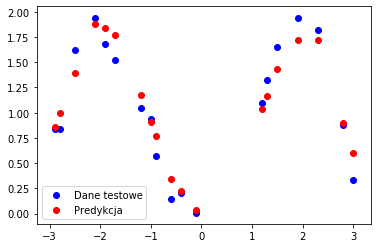

In [193]:
model = models.Sequential()
model.add(layers.Dense(units=16, activation='relu', input_shape=(1,)))
model.add(layers.Dense(units=16, activation='relu'))
model.add(layers.Dense(units=16, activation='relu'))
model.add(layers.Dense(units=16, activation='relu'))
model.add(layers.Dense(units=1))

model.compile(optimizer='RMSProp',
              loss='mean_squared_error',
              metrics=['mean_squared_error', 'mean_absolute_error'])

history = model.fit(x_train,
                    y_train,
                    epochs=300,
                    batch_size=8,
                    verbose=0)

results = model.evaluate(x_test, y_test)

print('Dokładność wytrenowanego modelu:')
print('\tEtykiety: ', model.metrics_names)
print('\tWartości: ', results)

predictions = model.predict(x_test)
printResults(x_test, y_test, predictions)
